# 🔭 Measuring Cosmological Parameters Using Type Ia Supernovae

In this work, we analyze observational data from the Pantheon+SH0ES Type Ia supernovae dataset to study the expansion of the universe. Using this dataset, we investigate key cosmological parameters, with a primary focus on the Hubble constant \( H_0 \) and the age of the universe.

We begin by constructing the Hubble diagram, plotting distance modulus as a function of redshift to visualize the cosmic expansion. A cosmological model is then fitted to the data to obtain estimates of the Hubble constant \( H_0 \) and the matter density parameter \( \Omega_m \).

Using the best-fit cosmological parameters, we estimate the age of the universe and assess the quality of the model through residual analysis. To further understand the dependence of the results on model assumptions, we explore the effect of fixing \( \Omega_m \) to a constant value.

Finally, we compare results obtained from low-redshift and high-redshift supernova samples to examine consistency and identify possible systematic differences in the inferred cosmological parameters.


## 📦 Setup and Libraries

To carry out the analysis, we first import the required Python libraries for numerical computation, data handling, visualization, and cosmological calculations.

We use `numpy` and `pandas` for numerical operations and managing the supernova dataset. Data visualization is performed using `matplotlib`. Model fitting and numerical integration are handled using `scipy`, while `astropy` provides physical constants and unit conversions essential for cosmological calculations.

All required libraries should be available in the working environment. If any of them are missing, they can be installed using:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
from astropy.constants import c
from astropy import units as u

## 📂 Loading the Pantheon+SH0ES Dataset

At this stage, we load the observational Type Ia supernova data from the Pantheon+SH0ES sample. This dataset provides calibrated distance moduli, redshifts corrected for various observational effects, and corresponding measurement uncertainties.

The data file is read directly from a locally stored copy of the Pantheon+SH0ES release. Since the file is space-delimited rather than comma-separated, whitespace separation is used while loading the data. Commented lines in the file are automatically ignored during the read process.

From the dataset, we extract the key quantities required for our analysis:
- **`zHD`**: Redshift used for constructing the Hubble diagram  
- **`MU_SH0ES`**: Distance modulus calibrated using the SH0ES methodology  
- **`MU_SH0ES_ERR_DIAG`**: Associated uncertainty in the distance modulus  


In [5]:
import os
import pandas as pd

# Get the directory where the current notebook is located
notebook_dir = os.getcwd()

# Data file assumed to be in the same directory as the notebook
data_file = os.path.join(notebook_dir, "Pantheon+SH0ES.dat")

# Load the file
df = pd.read_csv(
    data_file,
    delim_whitespace=True,   # important for .dat file
    comment="#"
)

# Preview structure
print(df.columns)
df[['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG']].head()


Index(['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL',
       'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES',
       'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF',
       'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c',
       'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC',
       'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB',
       'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b',
       'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD'],
      dtype='object')


/tmp/ipykernel_13204/1166868071.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,zHD,MU_SH0ES,MU_SH0ES_ERR_DIAG
0,0.00122,28.9987,1.516450
1,0.00122,29.0559,1.517470
2,0.00256,30.7233,0.782372
3,0.00256,30.7449,0.799068
4,0.00299,30.7757,0.881212


## 🧾 Previewing Dataset Columns

Before proceeding with the analysis, we briefly inspect the column names in the dataset. This step confirms that the data have been loaded correctly and helps identify the variables required for cosmological modeling and subsequent analysis.


In [6]:
df.columns

Index(['CID', 'IDSURVEY', 'zHD', 'zHDERR', 'zCMB', 'zCMBERR', 'zHEL',
       'zHELERR', 'm_b_corr', 'm_b_corr_err_DIAG', 'MU_SH0ES',
       'MU_SH0ES_ERR_DIAG', 'CEPH_DIST', 'IS_CALIBRATOR', 'USED_IN_SH0ES_HF',
       'c', 'cERR', 'x1', 'x1ERR', 'mB', 'mBERR', 'x0', 'x0ERR', 'COV_x1_c',
       'COV_x1_x0', 'COV_c_x0', 'RA', 'DEC', 'HOST_RA', 'HOST_DEC',
       'HOST_ANGSEP', 'VPEC', 'VPECERR', 'MWEBV', 'HOST_LOGMASS',
       'HOST_LOGMASS_ERR', 'PKMJD', 'PKMJDERR', 'NDOF', 'FITCHI2', 'FITPROB',
       'm_b_corr_err_RAW', 'm_b_corr_err_VPEC', 'biasCor_m_b',
       'biasCorErr_m_b', 'biasCor_m_b_COVSCALE', 'biasCor_m_b_COVADD'],
      dtype='object')

## 🧹 Cleaning and Extracting Relevant Data

To ensure a robust and reliable model fit, we first clean the dataset by removing entries with missing values in the key variables used for the analysis. These variables include the redshift used for the Hubble diagram, the calibrated distance modulus, and its associated uncertainty.

After filtering the dataset, the relevant columns are extracted and converted into NumPy arrays. This format is well suited for numerical analysis and cosmological model fitting in the subsequent steps.


In [7]:
# Filter for entries with usable data
df_clean = df.dropna(subset=['zHD', 'MU_SH0ES', 'MU_SH0ES_ERR_DIAG'])

z = df_clean['zHD'].values
mu = df_clean['MU_SH0ES'].values
mu_err = df_clean['MU_SH0ES_ERR_DIAG'].values

## 📈 Plotting the Hubble Diagram

We now visualize the relationship between redshift \( z \) and distance modulus \( \mu \), commonly referred to as the Hubble diagram. This plot plays a central role in observational cosmology, as it enables a direct comparison between supernova observations and theoretical predictions from cosmological models.

A logarithmic scale is used for the redshift axis to clearly represent both nearby and distant supernovae on the same plot.


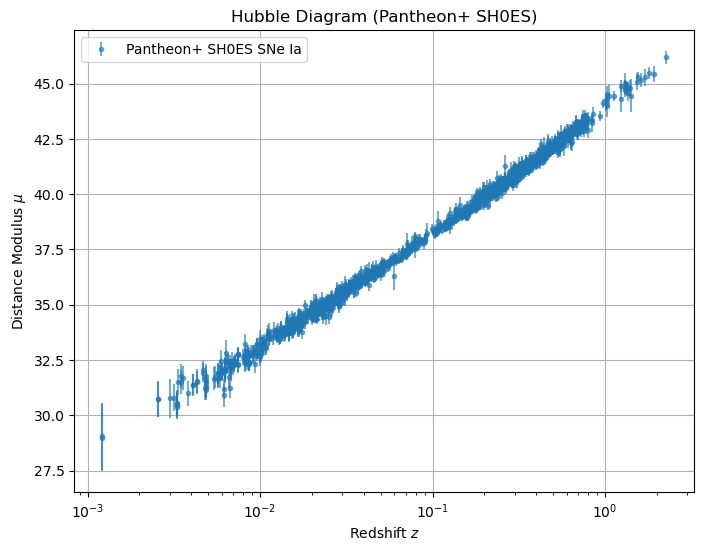

In [8]:
plt.figure(figsize=(8, 6))
plt.errorbar(z, mu, yerr=mu_err, fmt='.', alpha=0.6, label='Pantheon+ SH0ES SNe Ia')
plt.xlabel("Redshift $z$")
plt.ylabel("Distance Modulus $\\mu$")
plt.title("Hubble Diagram (Pantheon+ SH0ES)")
plt.grid(True)
plt.legend()
plt.xscale("log")
plt.show()


## 🧮 Defining the Cosmological Model

We adopt the flat $\Lambda$CDM cosmological model to describe the expansion history of the universe. In this framework, the expansion rate is governed by the matter density parameter $\Omega_m$ and the Hubble constant $H_0$.

The dimensionless Hubble parameter is defined as:

$$
E(z) = \sqrt{\Omega_m (1+z)^3 + (1 - \Omega_m)}
$$

Using this expression, the luminosity distance is given by:

$$
d_L(z) = (1 + z)\,\frac{c}{H_0} \int_0^z \frac{dz'}{E(z')}
$$

Finally, the theoretical distance modulus is computed as:

$$
\mu(z) = 5 \log_{10}\!\left(\frac{d_L}{\mathrm{Mpc}}\right) + 25
$$

These relations allow us to predict the distance modulus for a given redshift, enabling direct comparison with supernova observations.


In [9]:
# Define the E(z) for flat LCDM
def E(z, Omega_m):
    return np.sqrt(Omega_m * (1 + z)**3 + (1 - Omega_m))

# Luminosity distance in Mpc
def luminosity_distance(z, H0, Omega_m):
    integral = np.array([quad(lambda z_: 1/E(z_, Omega_m), 0, zi)[0] for zi in z])
    return (c.to('km/s').value / H0) * (1 + z) * integral

# Theoretical distance modulus
def mu_theory(z, H0, Omega_m):
    dL = luminosity_distance(z, H0, Omega_m)
    return 5 * np.log10(dL) + 25


## 🔧 Fitting the Model to Supernova Data

We now fit the flat $\Lambda$CDM model to the supernova observations using a non-linear least squares approach. This procedure allows us to estimate the best-fit values of the Hubble constant $H_0$ and the matter density parameter $\Omega_m$, along with their statistical uncertainties.

The fit is performed by comparing the observed distance modulus $\mu(z)$ with the theoretical prediction from the cosmological model, taking into account the measurement uncertainties.

For the fitting procedure, we use:
- `curve_fit` from `scipy.optimize`
- Observed redshifts $z$, distance moduli $\mu$, and their uncertainties

The initial parameter values are chosen as:
- $H_0 = 70\ \mathrm{km\,s^{-1}\,Mpc^{-1}}$
- $\Omega_m = 0.3$


In [11]:
# Initial guess: H0 = 70, Omega_m = 0.3
p0 = [70, 0.3]

popt, pcov = curve_fit(mu_theory, z, mu, sigma=mu_err, p0=p0, absolute_sigma=True)
H0_fit, Omega_m_fit = popt
H0_err, Omega_m_err = np.sqrt(np.diag(pcov))

print(f"Fitted H0 = {H0_fit:.2f} ± {H0_err:.2f} km/s/Mpc")
print(f"Fitted Omega_m = {Omega_m_fit:.3f} ± {Omega_m_err:.3f}")


Fitted H0 = 72.97 ± 0.26 km/s/Mpc
Fitted Omega_m = 0.351 ± 0.019


## ⏳ Estimating the Age of the Universe

Using the best-fit values of the Hubble constant $H_0$ and matter density parameter $\Omega_m$, we estimate the age of the universe within the flat $\Lambda$CDM framework.

The age of the universe is obtained by integrating the inverse of the Hubble expansion rate over redshift:

$$
t_0 = \int_0^\infty \frac{1}{(1 + z)\,H(z)} \, dz
$$

where the Hubble parameter is given by $H(z) = H_0\,E(z)$. The Hubble constant is converted to SI units, and the final result is expressed in gigayears (Gyr).

This estimate provides an important consistency check by allowing comparison with independent measurements, such as those derived from cosmic microwave background observations.


In [12]:
def age_of_universe(H0, Omega_m):
    integrand = lambda z: 1 / ((1 + z) * E(z, Omega_m))
    integral, _ = quad(integrand, 0, np.inf)
    H0_SI = (H0 * u.km / u.s / u.Mpc).to(1/u.s).value
    t_sec = integral / H0_SI
    return t_sec / (3600 * 24 * 365.25 * 1e9)  # Gyr

t0 = age_of_universe(H0_fit, Omega_m_fit)
print(f"Estimated age of Universe: {t0:.2f} Gyr")


Estimated age of Universe: 12.36 Gyr


## 📊 Analyzing Residuals

To assess the quality of the cosmological fit, we compute the residuals between the observed and model-predicted distance moduli:

$$
\mathrm{Residual} = \mu_{\mathrm{obs}} - \mu_{\mathrm{model}}
$$

Examining the residuals as a function of redshift provides a powerful diagnostic of model performance. A well-fitting cosmological model should produce residuals that are randomly scattered around zero, with no systematic trends or redshift-dependent structure.


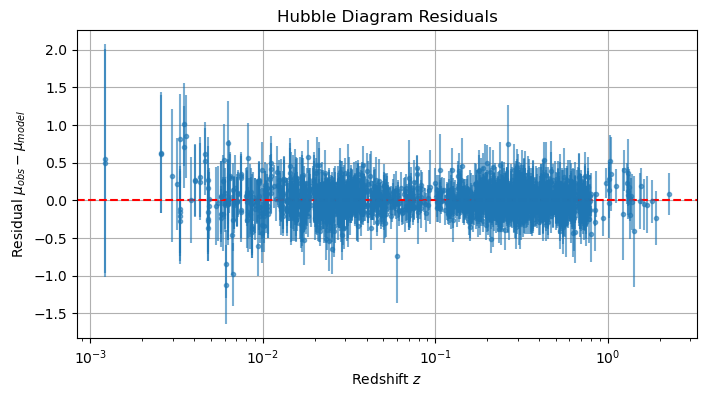

In [13]:
mu_model = mu_theory(z, H0_fit, Omega_m_fit)
residuals = mu - mu_model

plt.figure(figsize=(8, 4))
plt.errorbar(z, residuals, yerr=mu_err, fmt='.', alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Redshift $z$")
plt.ylabel("Residual $\\mu_{obs} - \\mu_{model}$")
plt.title("Hubble Diagram Residuals")
plt.grid(True)
plt.xscale("log")
plt.show()

## 🔧 Fitting with Fixed Matter Density

To reduce parameter degeneracy and isolate the dependence on the Hubble constant, we repeat the fitting procedure while fixing the matter density parameter to $\Omega_m = 0.3$. In this case, only $H_0$ is treated as a free parameter.

This approach allows us to examine how strongly the inferred value of the Hubble constant depends on assumptions about the matter content of the universe.


In [14]:
def mu_fixed_Om(z, H0):
    return mu_theory(z, H0, Omega_m=0.3)

popt_fixed, pcov_fixed = curve_fit(mu_fixed_Om, z, mu, sigma=mu_err, p0=[70])
H0_fixed = popt_fixed[0]
H0_fixed_err = np.sqrt(pcov_fixed[0][0])

print(f"Fixed Ωₘ = 0.3, Fitted H₀ = {H0_fixed:.2f} ± {H0_fixed_err:.2f} km/s/Mpc")

t0 = age_of_universe(H0_fixed, 0.3)
print(f"Estimated age of Universe: {t0:.2f} Gyr")

Fixed Ωₘ = 0.3, Fitted H₀ = 73.53 ± 0.11 km/s/Mpc
Estimated age of Universe: 12.82 Gyr


## 🔍 Comparing Low- and High-Redshift Subsamples

To investigate potential redshift-dependent effects in the inferred value of the Hubble constant, the supernova dataset is divided into two subsamples:

- **Low-redshift (Low-z)** supernovae with $z < 0.1$
- **High-redshift (High-z)** supernovae with $z \geq 0.1$

Each subsample is fitted independently while fixing the matter density parameter to $\Omega_m = 0.3$. This comparison allows us to explore possible trends, systematic effects, or tensions in the determination of $H_0$ across different redshift regimes.


In [16]:
# Split the data
z_split = 0.1
z_low = z[z < z_split]
mu_low = mu[z < z_split]
mu_err_low = mu_err[z < z_split]

z_high = z[z >= z_split]
mu_high = mu[z >= z_split]
mu_err_high = mu_err[z >= z_split]

# Fit both separately
H0_low, _ = curve_fit(mu_fixed_Om, z_low, mu_low, sigma=mu_err_low, p0=[70])
H0_high, _ = curve_fit(mu_fixed_Om, z_high, mu_high, sigma=mu_err_high, p0=[70])

print(f"Low-z (z < {z_split}): H₀ = {H0_low[0]:.2f} km/s/Mpc")
print(f"High-z (z ≥ {z_split}): H₀ = {H0_high[0]:.2f} km/s/Mpc")


Low-z (z < 0.1): H₀ = 73.01 km/s/Mpc
High-z (z ≥ 0.1): H₀ = 73.85 km/s/Mpc
